In [1]:
import pandas as pd
import numpy as np
import sys, os
import seaborn as sns
from scipy.stats import hypergeom
from sklearn.metrics import normalized_mutual_info_score
from topicpy.hsbmpy import get_max_available_L, get_scores, add_score_lines
import matplotlib.pyplot as plt
import multiprocessing as mp
from time import time
import logging
log = logging.getLogger()

In [2]:
population=pd.read_csv("https://stephenslab.github.io/count-clustering/project/utilities/gene_names_all_gtex.txt", header=None).values.ravel()

In [3]:
df_files = pd.read_csv("https://storage.googleapis.com/gtex_analysis_v8/annotations/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt", sep='\t').loc[:,['SAMPID','SMTS', 'SMTSD']]
df_files.set_index('SAMPID', inplace=True)

In [4]:
palette = sns.diverging_palette(240, 10, sep=20, as_cmap=True)

In [5]:
work_dir = "/home/jovyan/work/phd/topics/datasets/"

In [6]:
experiments = ["gtex10", "gtexhk", "random/random00", "random/random11", "random/random22", "random/random33", "random/random44", "random/random55", "random/random66", "random/random77", "random/random88", "random/random99"]
#experiments = ["gtex10","gtexall","gtexhk","random/random11"]
genes = []
for directory in experiments:
    genes.append(pd.read_csv(f"{work_dir}/{directory}/mainTable.csv", index_col=0).index)

In [7]:
def get_pval(setA, setB):
    x = setA.isin(setB).sum() # number of successes
    M = len(population) # pop size
    k = len(setB) # successes in pop
    N = len(setA) # sample size
    pval = hypergeom.sf(x-1, M, k, N)
    return pval
#-np.log10(get_pval(setA, setB)+1)

In [8]:
overlaps = list(map(lambda setA: list(map(lambda setB: setA.isin(setB).sum()/float(len(setA)), genes)), genes))

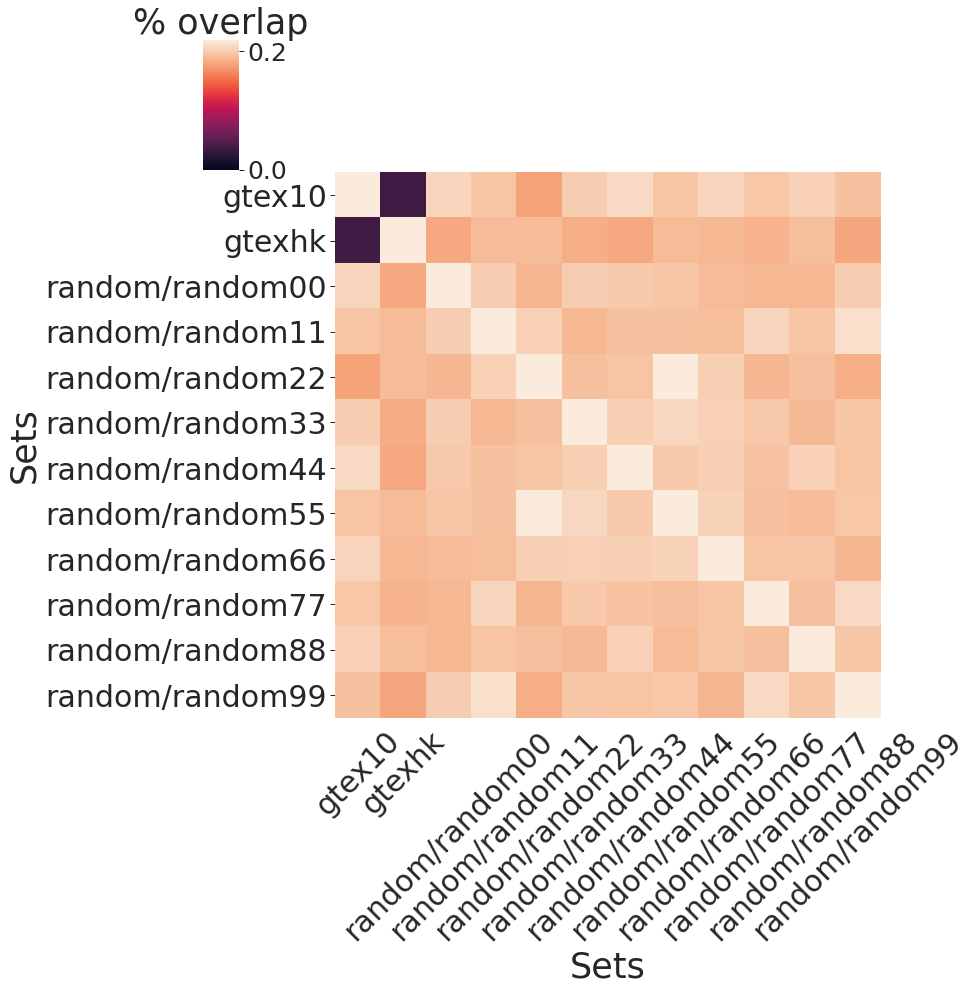

In [9]:
cm = sns.clustermap(
    overlaps, 
    row_cluster=False,
    col_cluster=False, 
    vmin=0,
    vmax=max(list(map(lambda x: max(filter(lambda xi: xi<1,x)), overlaps)))
)

ax = cm.ax_heatmap
ax.yaxis.set_label_position("left")
ax.yaxis.tick_left()
ax.set_ylabel("Sets", fontsize=35)
ax.set_xlabel("Sets", fontsize=35)
ax.set_xticklabels(experiments, rotation=45)
ax.set_yticklabels(experiments, rotation=0)

ax.tick_params(labelsize=30)


bax = cm.ax_cbar
bax.tick_params(labelsize=25)
bax.set_title("% overlap", fontsize=35)

plt.show()
cm.savefig("selection_overlap.pdf")

In [79]:
algorithm = "tm"

In [80]:
def get_scores_mp(directory):
    return directory, get_scores(work_dir+directory, ["SMTS"], algorithm=algorithm, df_files=df_files)["SMTS"]

def get_scores_clbck(packed_score):
    global scores
    scores[packed_score[0]]=packed_score[1]

In [81]:
scores = {}
        
start = time()
    
pool = mp.Pool(12)

work = [pool.apply_async(get_scores_mp, args=([directory]), callback=get_scores_clbck, error_callback=lambda err:print(err)) for directory in experiments]

pool.close()
pool.join()

print(time()-start)

2.8866772651672363


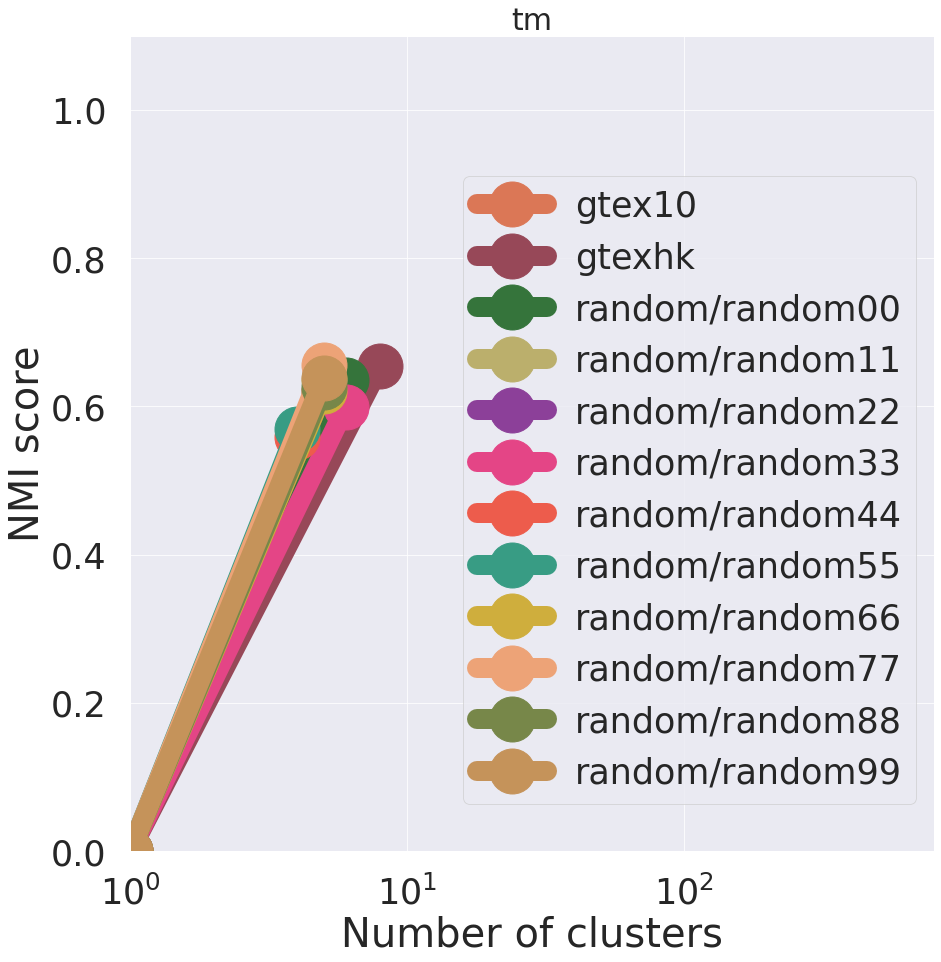

In [82]:
fig, ax = plt.subplots(figsize=(18,15))
add_score_lines(ax, scores, labels = experiments)
ax.set_title(algorithm, fontsize=30)
ax.set_xlim(1,800)
fig.savefig(f"scores_selections_{algorithm}.pdf")

In [83]:
def get_exp_labels(experiment):
    global files
    #print(experiment)
    level = get_max_available_L(work_dir+experiment, algorithm)
    df_clusters = pd.read_csv(f"{work_dir}/{experiment}/{algorithm}/{algorithm}_level_{level}_clusters.csv")
    exp_data = []
    new_idx = files.index[files.index.isin(df_clusters.values.ravel())]
    for file in new_idx:
        exp_data.append(df_clusters.columns[df_clusters[df_clusters==file].any(0)].values[0].split(" ")[1])
    return pd.Series(name=experiment, data=exp_data, index = new_idx)

def exp_clbck(exp_series):
    global files
    files = files.join(exp_series, how="outer")

In [84]:
experiments = ["gtex10", "gtexhk", "random/random00", "random/random11", "random/random22", "random/random33", "random/random44", "random/random55", "random/random66", "random/random77", "random/random88", "random/random99"]
#experiments = ["gtex10", "gtexhk", "random/random11", "random/random22", "random/random33"]

In [85]:
files = pd.DataFrame(index=df_files.index)
scores = {}
        
start = time()
    
pool = mp.Pool(4)

work = [pool.apply_async(get_exp_labels, args=([directory]), callback=exp_clbck, error_callback=lambda err:print(err)) for directory in experiments]

pool.close()
pool.join()

print(time()-start)

6.348250389099121


In [86]:
partitions = files.transpose().values

In [87]:
def score(A, B):
    mask = ~(np.isnan(A.astype(float)) | np.isnan(B.astype(float))) #demorgan law
    return normalized_mutual_info_score(A[mask], B[mask])

partition_overlap = list(map(lambda partitionA: list(map(lambda partitionB: score(partitionA, partitionB), partitions)), partitions))

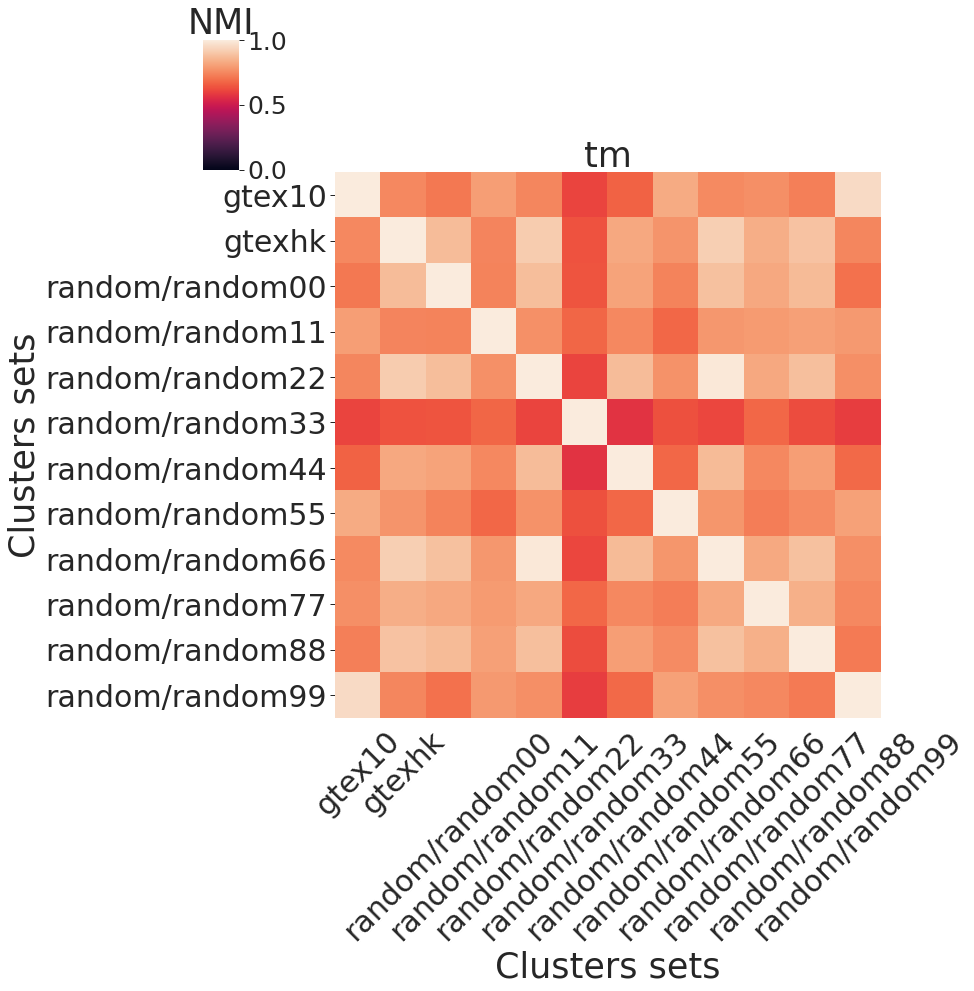

In [88]:
cm = sns.clustermap(
    partition_overlap, 
    row_cluster=False,
    col_cluster=False,
    vmin=0.0
)

ax = cm.ax_heatmap
ax.set_title(algorithm, fontsize=35)
ax.yaxis.set_label_position("left")
ax.yaxis.tick_left()
ax.set_ylabel("Clusters sets", fontsize=35)
ax.set_xlabel("Clusters sets", fontsize=35)
ax.tick_params(labelsize=30)
ax.set_xticklabels(experiments, rotation=45)
ax.set_yticklabels(experiments, rotation=0)

bax = cm.ax_cbar
bax.tick_params(labelsize=25)
bax.set_title("NMI", fontsize=35)

plt.show()
cm.savefig(f"cluster_overlap_{algorithm}.pdf")

# Compare algorithms

## topics

In [89]:
def get_exp_topic_labels(algorithm, experiment):
    global files_topic
    #print(experiment)
    levels = {
        "gtex10":{
            "topsbm": 3,
            "topsbm-log": 2,
            "lda": 2,
            "tm":0,
            "wgcna":0
        },
        "gtexhk":{
            "topsbm": 1,
            "lda": 1,
            "tm":0,
            "wgcna":0
        }
    }
    level = levels[experiment][algorithm]
    df_topics = pd.read_csv(f"{work_dir}/{experiment}/{algorithm}/{algorithm}_level_{level}_topics.csv")
    exp_data = []
    new_idx = files_topic.index[files_topic.index.isin(df_topics.values.ravel())]
    df_topics.columns = np.unique(df_topics.columns, return_inverse=True)[1]
    for file in new_idx:
        exp_data.append(df_topics.columns[df_topics[df_topics==file].any(0)].values[0])
    return pd.Series(name=algorithm, data=exp_data, index = new_idx)

def exp_topic_clbck(exp_series):
    global files_topic
    files_topic = files_topic.join(exp_series, how="outer")

In [90]:
algorithms = ["topsbm", "topsbm-log", "lda", "tm", "wgcna"]
experiment = experiments[0]

In [91]:
files_topic = pd.DataFrame(index=population)
scores = {}
        
start = time()
    
pool = mp.Pool(2)

work = [pool.apply_async(get_exp_topic_labels, args=([alg, experiment]), callback=exp_topic_clbck, error_callback=lambda err:print(err)) for alg in algorithms]

pool.close()
pool.join()

print(time()-start)

16.212066888809204


In [92]:
files_topic.max(axis=0).astype(int)

topsbm-log    21
lda           28
tm             4
topsbm        21
wgcna         20
dtype: int64

In [93]:
partitions_topics = files_topic.transpose().values

In [94]:
def score(A, B):
    mask = ~(np.isnan(A.astype(float)) | np.isnan(B.astype(float))) #demorgan law
    return normalized_mutual_info_score(A[mask], B[mask])
    
partition_topics_overlap = list(map(lambda partitionA: list(map(lambda partitionB: score(partitionA, partitionB), partitions_topics)), partitions_topics))

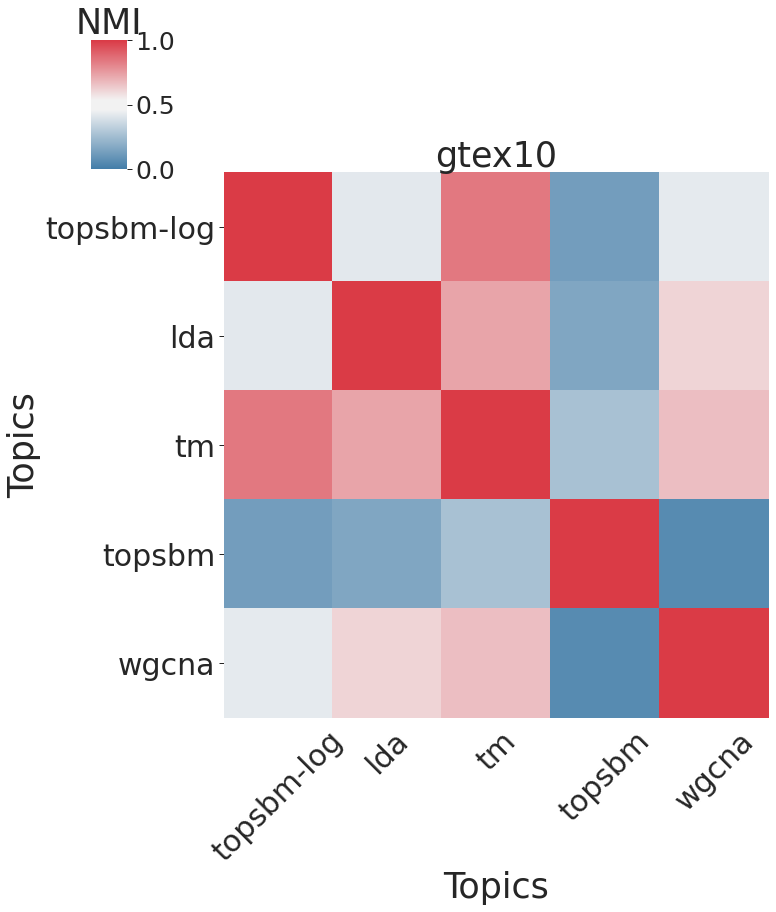

In [95]:
cm = sns.clustermap(
    partition_topics_overlap, 
    row_cluster=False,
    col_cluster=False,
    vmin=0.0,
    cmap = palette
)

ax = cm.ax_heatmap
ax.set_title(experiment, fontsize=35)
ax.yaxis.set_label_position("left")
ax.yaxis.tick_left()
ax.set_ylabel("Topics", fontsize=35)
ax.set_xlabel("Topics", fontsize=35)
ax.tick_params(labelsize=30)
ax.set_xticklabels(files_topic.columns, rotation=45)
ax.set_yticklabels(files_topic.columns, rotation=0)

bax = cm.ax_cbar
bax.tick_params(labelsize=25)
bax.set_title("NMI", fontsize=35)

plt.show()
cm.savefig(f"topic_overlap_{experiment}.pdf")

## clusters

In [96]:
def get_exp_cluster_labels(algorithm, experiment):
    global files_topic
    #print(experiment)
    levels = {
        "topsbm": 1,
        "topsbm-log":1,
        "lda": 1,
        "tm":0,
        "wgcna":1
    }
    #level = get_max_available_L(work_dir+experiment, algorithm)
    level = levels[algorithm]
    df_clusters = pd.read_csv(f"{work_dir}/{experiment}/{algorithm}/{algorithm}_level_{level}_clusters.csv")
    exp_data = []
    new_idx = files_cluster.index[files_cluster.index.isin(df_clusters.values.ravel())]
    df_clusters.columns = np.unique(df_clusters.columns, return_inverse=True)[1]
    for file in new_idx:
        exp_data.append(df_clusters.columns[df_clusters[df_clusters==file].any(0)].values[0])
    return pd.Series(name=algorithm, data=exp_data, index = new_idx)

def exp_topic_clbck(exp_series):
    global files_cluster
    files_cluster = files_cluster.join(exp_series, how="outer")

In [97]:
files_cluster = pd.DataFrame(index=df_files.index)
scores = {}
        
start = time()
    
pool = mp.Pool(4)

work = [pool.apply_async(get_exp_cluster_labels, args=([alg, experiment]), callback=exp_topic_clbck, error_callback=lambda err:print(err)) for alg in algorithms]

pool.close()
pool.join()

print(time()-start)

6.7602698802948


In [98]:
files_cluster.max(axis=0).astype(int)

tm             4
lda            7
topsbm-log    11
topsbm        28
wgcna         29
dtype: int64

In [99]:
partitions_clusters = files_cluster.transpose().values

In [100]:
partition_clusters_overlap = list(map(lambda partitionA: list(map(lambda partitionB: score(partitionA, partitionB), partitions_clusters)), partitions_clusters))

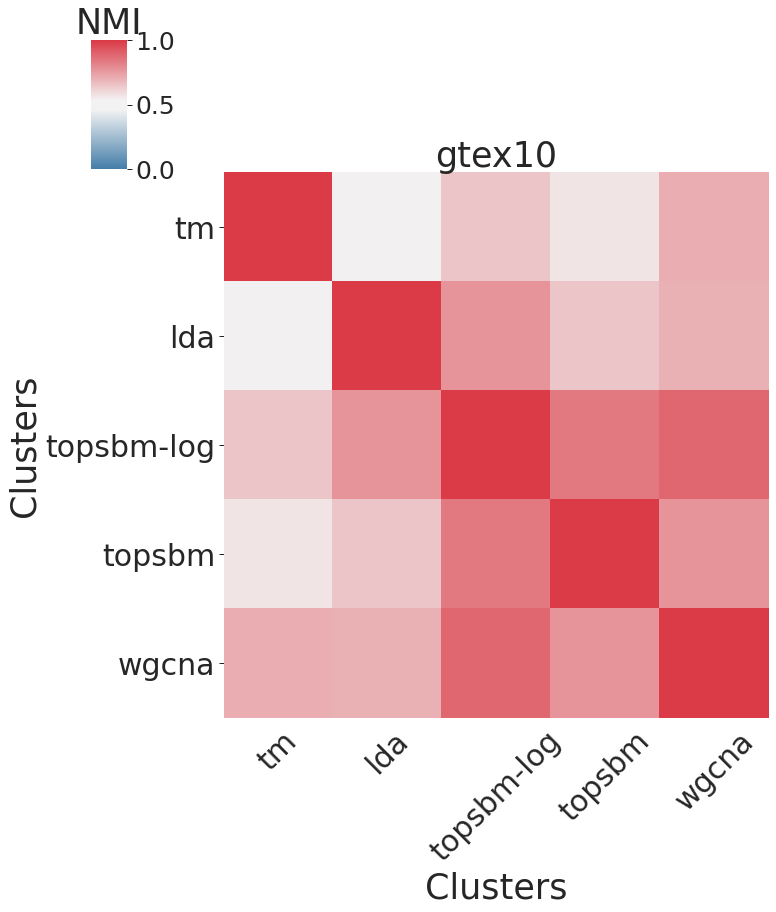

In [101]:
cm = sns.clustermap(
    partition_clusters_overlap, 
    row_cluster=False,
    col_cluster=False,
    vmin=0.0,
    cmap = palette
)

ax = cm.ax_heatmap
ax.set_title(experiment, fontsize=35)
ax.yaxis.set_label_position("left")
ax.yaxis.tick_left()
ax.set_ylabel("Clusters", fontsize=35)
ax.set_xlabel("Clusters", fontsize=35)
ax.tick_params(labelsize=30)
ax.set_xticklabels(files_cluster.columns, rotation=45)
ax.set_yticklabels(files_cluster.columns, rotation=0)

bax = cm.ax_cbar
bax.tick_params(labelsize=25)
bax.set_title("NMI", fontsize=35)

plt.show()
cm.savefig(f"cluster_overlap_{experiment}.pdf")